# Phase B: Model Diagnostics & Advanced Feature Engineering
**Project:** Real Estate Price Prediction (Queretaro, Mexico)
**Objective:** Diagnose the econometric anomalies found in the Baseline BigQuery models and implement feature engineering to resolve multicollinearity and endogeneity issues.

## 1. Baseline Model "Post-Mortem" Analysis
In Phase A, we trained two baseline models using BigQuery ML:
1.  **Model A (Linear):** Target = `price` ($R^2 \approx 0.645$)
2.  **Model B (Log-Linear):** Target = `ln(price)` ($R^2 \approx 0.623$)

While the $R^2$ results successfully replicated the explanatory power of the reference paper (Guanajuato study), the coefficient analysis revealed three **econometric paradoxes** that must be addressed before model tuning:

| model\_name | feature\_name | coefficient | standard\_error | p\_value | significance\_level |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Model A \(Linear\) | \_\_INTERCEPT\_\_ | -3569918.99 | 368817.35 | 0 | \*\*\* Highly Significant |
| Model A \(Linear\) | feat\_bathrooms | 688079.31 | 50238.23 | 0 | \*\*\* Highly Significant |
| Model A \(Linear\) | feat\_bedrooms | -492347.23 | 65832.46 | 0 | \*\*\* Highly Significant |
| Model A \(Linear\) | feat\_crime\_consolidated | 5756.01 | 399.49 | 0 | \*\*\* Highly Significant |
| Model A \(Linear\) | feat\_crime\_homicide | 60931.28 | 33203.45 | 0.066 | \* Marginally Significant |
| Model A \(Linear\) | feat\_dist\_center | -122.93 | 17.66 | 0 | \*\*\* Highly Significant |
| Model A \(Linear\) | feat\_dist\_park | -244.36 | 44.65 | 0 | \*\*\* Highly Significant |
| Model A \(Linear\) | feat\_dist\_supermarket | 238.07 | 29.54 | 0 | \*\*\* Highly Significant |
| Model A \(Linear\) | feat\_has\_garden | 354276.87 | 101621.16 | 0.0008 | \*\*\* Highly Significant |
| Model A \(Linear\) | feat\_m2\_constructed | 22112.04 | 282.79 | 0 | \*\*\* Highly Significant |
| Model A \(Linear\) | feat\_parking\_spots | 486444.87 | 28637.46 | 0 | \*\*\* Highly Significant |
| Model B \(Log-Linear\) | \_\_INTERCEPT\_\_ | 14.0734 | 0.0365 | 0 | \*\*\* Highly Significant |
| Model B \(Log-Linear\) | feat\_bathrooms | 0.1811 | 0.0051 | 0 | \*\*\* Highly Significant |
| Model B \(Log-Linear\) | feat\_bedrooms | -0.0272 | 0.0066 | 0.0001 | \*\*\* Highly Significant |
| Model B \(Log-Linear\) | feat\_crime\_consolidated | 0.0005 | 0 | 0 | \*\*\* Highly Significant |
| Model B \(Log-Linear\) | feat\_crime\_homicide | -0.0121 | 0.0033 | 0.0004 | \*\*\* Highly Significant |
| Model B \(Log-Linear\) | feat\_dist\_center | 0 | 0 | 0.7211 | Not Significant \(Likely Noise\) |
| Model B \(Log-Linear\) | feat\_dist\_park | -0 | 0 | 0.1956 | Not Significant \(Likely Noise\) |
| Model B \(Log-Linear\) | feat\_dist\_supermarket | 0 | 0 | 0.0874 | \* Marginally Significant |
| Model B \(Log-Linear\) | feat\_has\_garden | 0.1832 | 0.0102 | 0 | \*\*\* Highly Significant |
| Model B \(Log-Linear\) | feat\_m2\_constructed | 0.002 | 0 | 0 | \*\*\* Highly Significant |
| Model B \(Log-Linear\) | feat\_parking\_spots | 0.0393 | 0.0029 | 0 | \*\*\* Highly Significant |


### A. The "Negative Bedroom" Paradox
* **Observation:** The coefficient for `feat_bedrooms` was **negative** (-492,347 MXN in Linear model).
* **Interpretation:** The model suggests that adding a bedroom *reduces* the house value by half a million pesos, holding other factors constant.
* **Diagnosis:** High probability of **Multicollinearity**. Since `feat_m2_constructed` (size) is already in the model, `bedrooms` and `size` are fighting to explain the same variance. A small house with many rooms implies tiny, lower-value rooms.

### B. The "Crime Value" Paradox
* **Observation:** The coefficient for `feat_crime_consolidated` was **positive** (+5,756 MXN).
* **Interpretation:** The model implies that higher crime rates are associated with *higher* property values.
* **Diagnosis:** **Endogeneity / Omitted Variable Bias**. Crime is likely acting as a proxy for **economic activity**. Wealthy areas attract more opportunistic crime than undeveloped areas. The model is confusing "wealthy target" with "valuable location."

### C. The "Vanishing Distance" Effect
* **Observation:** In the Log-Linear Model (Model B), distance variables (Park, Center) became statistically insignificant ($p\text{-value} > 0.05$).
* **Diagnosis:** The logarithmic transformation of the price compressed the variance so much that the subtle linear effect of distance was lost. This suggests the relationship between distance and price might be non-linear or strictly local (e.g., only matters within 500m).

---
## 2. Hypothesis & Action Plan
To resolve these issues and improve $R^2$ > 0.70, we will test the following hypotheses:

1. **H1 (Interaction Features):** Creating interaction terms (e.g., `bathrooms_per_bedroom`) will resolve the multicollinearity between size and room counts.

2. **H2 (Multicollinearity):** Removing `bedrooms` or creating an interaction term (e.g., `bathrooms_per_bedroom`) will stabilize the coefficients of physical characteristics.
3. **H3 (Crime Unbundling):** Instead of a consolidated crime rate, we will separate **Violent Crime** (expected negative impact) from **Property Crime** (proxy for wealth) to isolate the true "fear factor."
4. **H4 (Rich Features):** Incorporating specific amenities (Schools, Hospitals) will capture the variance currently attributed to "noise" in the Baseline.

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import bigquery
from statsmodels.stats.outliers_influence import variance_inflation_factor
from dotenv import load_dotenv

# Visualization Settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Initialize BigQuery Client
load_dotenv()

try:
    client = bigquery.Client()
    print("Successful connection to BigQuery (Authenticated via Environment Variables)")
except Exception as e:
    print(f"Connection Error: {e}")
    print("Tip: Verify that your .env file has the correct path to the JSON.")

print("Libraries loaded. Ready for diagnostics.")

Successful connection to BigQuery (Authenticated via Environment Variables)
Libraries loaded. Ready for diagnostics.


## 3. Data Loading: Unleashing the Full OBT (One Big Table)

In Phase A (Baseline), we intentionally restricted our analysis to a limited subset of variables to strictly replicate the methodology of the reference paper (Guanajuato study).

**Transition to Phase B:**
Now that the baseline is established, we proceed to unlock the full potential of our **One Big Table (OBT)**. Unlike the original study, our dataset includes a richer set of granular features collected from multiple sources.

**Key Additions in this Phase:**
* **Crime Granularity:** Instead of a consolidated sum, we access specific crime types (Homicide, Burglary, Violence, Vehicle Theft) to test the "Unbundling" hypothesis.
* **Expanded Amenities:** We include previously unused proximity features (Schools, Hospitals, etc.) to capture value drivers that were treated as "noise" in the baseline.
* **Full Physical Specs:** Detailed breakdown of property characteristics (e.g., Half-bathrooms, Age of construction).

We will now query the full `view_training_data_cleaned` to perform the advanced diagnostic.

In [24]:
# Query to fetch all potential features + target
query = """
SELECT
    -- Target
    target_price,

    -- Physical Features
    feat_m2_constructed,
    feat_m2_terrain,
    feat_bedrooms,
    feat_bathrooms,
    feat_parking_spots,

    -- Amenities
    feat_is_new,
    feat_has_security,
    feat_has_garden,
    feat_has_pool,
    feat_has_gym,
    feat_has_kitchen,
    feat_has_terrace,

    -- Municipality
    feat_municipality,

    -- Geographic Features (Distances)
    feat_dist_mall,
    feat_dist_park,
    feat_dist_industrial,
    feat_dist_green_area,
    feat_dist_playground,
    feat_dist_service,
    feat_dist_convenience,
    feat_dist_market,
    feat_dist_supermarket,
    feat_dist_center,
    feat_dist_tourism,

    -- Crime Features (Raw Counts)
    feat_crime_residential,
    feat_crime_vehicle,
    feat_crime_passerby,
    feat_crime_homicide,
    feat_crime_injueries,
    feat_crime_drug_dealing,
    feat_crime_violent

FROM `real-estate-qro.queretaro_data_marts.obt_listings_valuation_features`
WHERE target_price IS NOT NULL
"""

# Load to DataFrame
df = client.query(query).to_dataframe()

# Quick sanity check
print(f"Dataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")
df.head()

C:\Users\a-b-e\anaconda3\envs\real_estate_ds\lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Dataset Shape: 11840 rows, 32 columns


,target_price,feat_m2_constructed,feat_m2_terrain,feat_bedrooms,feat_bathrooms,feat_parking_spots,feat_is_new,feat_has_security,feat_has_garden,feat_has_pool,...,feat_dist_supermarket,feat_dist_center,feat_dist_tourism,feat_crime_residential,feat_crime_vehicle,feat_crime_passerby,feat_crime_homicide,feat_crime_injueries,feat_crime_drug_dealing,feat_crime_violent
0,3300000.000,39000.000,39000.000,5.000,5.000,5.000,1,0,0,0,...,16135.467,16371.798,2437.980,26.621,0.000,3.328,9.983,126.452,29.949,0.000
1,4440000.000,290.000,212.000,3.000,3.000,2.000,1,0,1,1,...,20000.000,9662.670,12920.501,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,3000000.000,124.000,90.000,3.000,3.000,1.000,1,0,1,1,...,20000.000,1844.340,20000.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,2690000.000,150.000,115.000,3.000,3.000,2.000,1,1,1,1,...,17730.578,16905.141,8779.006,53.115,5.902,0.000,0.000,132.786,20.656,2.951
4,2990000.000,175.000,115.000,3.000,3.000,2.000,1,1,1,1,...,17730.578,16905.141,8779.006,53.115,5.902,0.000,0.000,132.786,20.656,2.951


## 4. Comprehensive Data Integrity Check
Before proceeding to feature engineering, we must validate the integrity of the raw OBT data loaded from BigQuery. Unlike the initial SQL filtering, this step uses Pandas to detect subtle anomalies that could bias the model.

**We are looking for:**
1.  **Unexpected Zeros:** Are "0 bedrooms" real studio apartments or missing data?
2.  **Missing Values (NaNs):** Quantifying the emptiness of new columns.
3.  **Skewness:** Identifying which variables need the Log-Transformation proposed in **H4**.
4.  **Logic Errors:** e.g., Construction size > Land size (in single-family homes).

In [25]:
# --- DATA INTEGRITY REPORT ---

def check_integrity(df):
    """
    Generates a summary report of the dataframe's health.
    """

    # Nulls & Zeros Analysis
    integrity_df = pd.DataFrame({
        'Dtype': df.dtypes,
        'Nulls': df.isnull().sum(),
        'Null_Pct': (df.isnull().sum() / len(df)) * 100,
        'Zeros': (df == 0).sum(),
        'Zero_Pct': ((df == 0).sum() / len(df)) * 100,
        'Skewness': df.select_dtypes(include=[np.number]).skew()
    })

    # Filter only relevant columns (exclude IDs or non-numeric if needed)
    return integrity_df

# Execute the check
integrity_report = check_integrity(df)

# Display the report with highlighting for potential issues
# - High Null % -> Candidates for dropping or imputation
# - High Skewness (> 1 or < -1) -> Candidates for Log Transformation (H4)
# - Unexpected Zeros -> Potential data quality issues
print("\n--- Integrity Report  ---")
display(integrity_report)

# --- LOGIC CHECKS (Domain Specific) ---
print("\n--- Domain Logic Validation ---")

# Check 1: Houses with 0 Bedrooms, 0 Bathrooms, 0 construction, or 0 land
zero_beds = df[df['feat_bedrooms'] == 0].shape[0]
zero_baths = df[df['feat_bathrooms'] == 0].shape[0]
zero_construction = df[df['feat_m2_constructed'] == 0].shape[0]
zero_land = df[df['feat_m2_terrain'] == 0].shape[0]
print(f"Suspicious Records: 0 Bedrooms = {zero_beds}, 0 Bathrooms = {zero_baths}, 0 Construction = {zero_construction}, 0 Land = {zero_land}")

# Check 2: Construction > Land (Valid for apartments, suspicious for houses if we had that flag)
# For now, we just check the ratio
denser_than_land = df[df['feat_m2_constructed'] > df['feat_m2_terrain']].shape[0]
print(f"Properties with Construction > Land Area: {denser_than_land} (Normal for vertical housing)")

# Check 3: Price Outliers (Simple Min/Max check)
print(f"Price Range: ${df['target_price'].min():,.0f} - ${df['target_price'].max():,.0f}")


--- Integrity Report  ---


,Dtype,Nulls,Null_Pct,Zeros,Zero_Pct,Skewness
feat_bathrooms,float64,0,0.000,363,3.066,1.615
feat_bedrooms,float64,0,0.000,331,2.796,29.497
feat_crime_drug_dealing,float64,0,0.000,2,0.017,-0.680
feat_crime_homicide,float64,0,0.000,94,0.794,-0.901
feat_crime_injueries,float64,0,0.000,2,0.017,-1.899
feat_crime_passerby,float64,0,0.000,67,0.566,-0.096
feat_crime_residential,float64,0,0.000,2,0.017,-0.079
feat_crime_vehicle,float64,0,0.000,3,0.025,-0.759
feat_crime_violent,float64,0,0.000,61,0.515,-1.007
feat_dist_center,float64,0,0.000,42,0.355,0.066



--- Domain Logic Validation ---
Suspicious Records: 0 Bedrooms = 331, 0 Bathrooms = 363, 0 Construction = 447, 0 Land = 309
Properties with Construction > Land Area: 6324 (Normal for vertical housing)
Price Range: $150,000 - $9,700,000,000


### 4.1. Categorical Imbalance Check: Municipalities
Before encoding categorical variables, we assess the frequency distribution of municipalities. Categories with extremely low counts (e.g., < 30 listings) can lead to overfitting or unstable coefficients in Linear Regression.

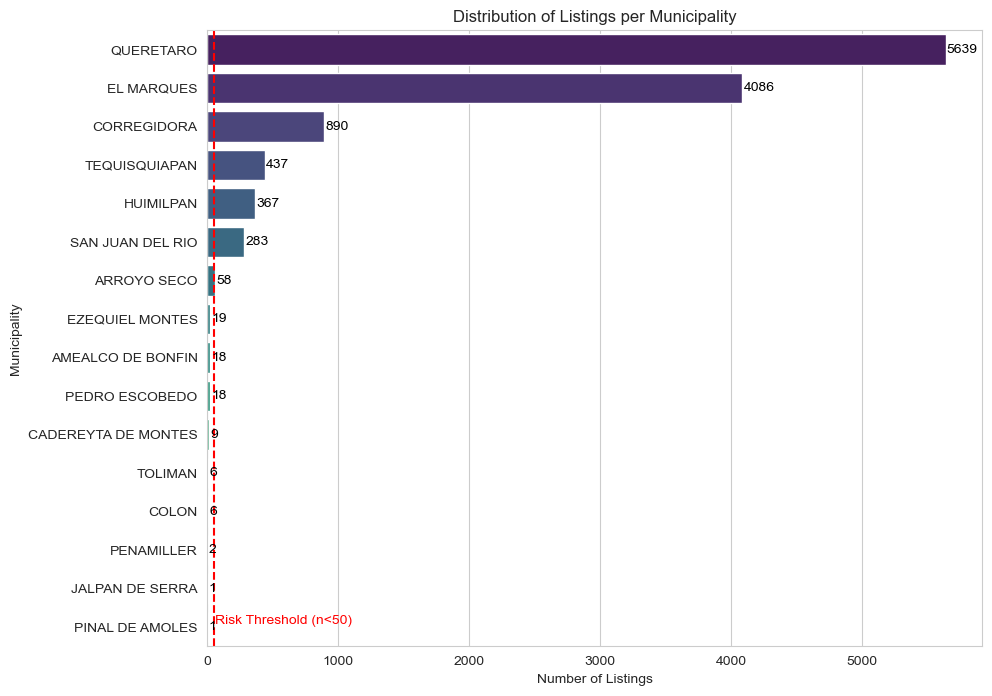

Municipalities with risk of low representation:
feat_municipality
EZEQUIEL MONTES        19
AMEALCO DE BONFIN      18
PEDRO ESCOBEDO         18
CADEREYTA DE MONTES     9
TOLIMAN                 6
COLON                   6
PENAMILLER              2
JALPAN DE SERRA         1
PINAL DE AMOLES         1
Name: count, dtype: int64


In [37]:
# --- MUNICIPALITY DISTRIBUTION CHECK (Pre-Encoding) ---

# Calculate frequencies directly from the text column
muni_counts = df['feat_municipality'].value_counts()

# Visualization
plt.figure(figsize=(10, len(muni_counts) * 0.5))
ax = sns.barplot(x=muni_counts.values, y=muni_counts.index, hue=muni_counts.index, palette='viridis', legend=False)

plt.title('Distribution of Listings per Municipality')
plt.xlabel('Number of Listings')
plt.ylabel('Municipality')

threshold = 50
plt.axvline(x=threshold, color='red', linestyle='--', linewidth=1.5)
plt.text(threshold + 5, len(muni_counts)-1, f'Risk Threshold (n<{threshold})', color='red', va='bottom')

# Show values in bars for clarification
for i, v in enumerate(muni_counts.values):
    ax.text(v + 10, i, str(v), color='black', va='center')

plt.show()

# Summary
print("Municipalities with risk of low representation:")
print(muni_counts[muni_counts < threshold])

## 5. Data Cleaning & Logic Filtering
The Integrity Report revealed critical issues that jeopardize model stability:
1.  **"Ghost" Properties:** Records with 0 bedrooms, 0 bathrooms, 0 land, or 0 constructed square meters. These correspond to **Land/Lots**, not habitable housing. We will filter them out to focus the model on Residential Real Estate (Houses/Apartments).
2.  **Extreme Skewness:** Variables like `m2_terrain` (Skew: 108) and `target_price` (Skew: 107) indicate massive outliers (likely industrial plots or data entry errors).
3.  **Zero Distances:** While plausible in mixed-use developments, accurate distance is key.

**Filtering Rules Applied:**
* `target_price`: Keep between $500k and $15M MXN (Focus on residential market, removing luxury mansions and errors).
* `m2_constructed`: Must be > 30 m² (removing lots and tiny errors).
* `m2_terrain`: Must be < 2,000 m² (removing ranches and industrial lots).
* `bedrooms` & `bathrooms`: Must be >= 1 (Must be habitable).

### 5.1. Stage A: Logical Filtering & Data Formatting
Before analyzing distributions, we must ensure the data is logically sound for a residential model and formatted correctly for statistical analysis.

**1. Row Filtering (Sanity Check):**
* Any record with **0 Bedrooms, 0 Bathrooms, or 0 Constructed $m^2$** is classified as a "Lot/Land" or data entry error. These are removed.

**2. Value Capping (Outlier Control):**
* Discrete variables like Bedrooms and Parking often contain extreme outliers (e.g., "30 parking spots" or "15 bedrooms") which are likely data entry errors or non-residential properties (hotels/offices).
* We apply a **Hard Cap** (e.g., max 10) to keep these variables within a realistic residential range.

**3. Categorical Encoding:**
* The `feat_municipality` variable is text-based. We convert it to numerical format using **One-Hot Encoding** (creating dummy variables) so it can be included in correlation and regression analyses.

In [6]:
# --- STAGE A: LOGICAL FILTERS & FORMATTING ---

print(f"Original Count: {df.shape[0]}")

# 1. ROW FILTERING: Identify rows with Zeros
# We assume a valid house must have at least 1 bedroom, 1 bathroom, and > 10m2 construction
mask_habitable = (df['feat_bedrooms'] > 0) & \
                 (df['feat_bathrooms'] > 0) & \
                 (df['feat_m2_constructed'] > 10)

df_logic = df[mask_habitable].copy()

dropped = df.shape[0] - df_logic.shape[0]
print(f"1. Row Filtering: Dropped {dropped} records (Land/Lots or Errors)")

# 2. VALUE CAPPING (Clip outliers)
# Forces values > 10 to become 10. This handles errors like "20 bedrooms".
cols_to_cap = ['feat_bedrooms', 'feat_bathrooms', 'feat_parking_spots']
cap_limit = 10

print(f"2. Value Capping (Max {cap_limit}):")
for col in cols_to_cap:
    if col in df_logic.columns:
        # Check how many were capped
        n_capped = (df_logic[col] > cap_limit).sum()
        df_logic[col] = df_logic[col].clip(upper=cap_limit)
        print(f"   - {col}: Capped {n_capped} values > {cap_limit}")

# 3. CATEGORICAL ENCODING (Municipality)
if 'feat_municipality' in df_logic.columns:
    print(f"3. Categorical Encoding: One-Hot Encoding applied to 'feat_municipality'")
    # drop_first=True avoids the Dummy Variable Trap (Multicollinearity)
    df_logic = pd.get_dummies(df_logic, columns=['feat_municipality'], prefix='muni', drop_first=True)
else:
    print("3. Categorical Encoding: 'feat_municipality' not found (skipped)")

# Update main df
df = df_logic.copy()

print(f"\n--- STAGE A COMPLETE ---")
print(f"Final Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Original Count: 11840
1. Row Filtering: Dropped 652 records (Land/Lots or Errors)
2. Value Capping (Max 10):
   - feat_bedrooms: Capped 21 values > 10
   - feat_bathrooms: Capped 9 values > 10
   - feat_parking_spots: Capped 60 values > 10
3. Categorical Encoding: One-Hot Encoding applied to 'feat_municipality'

--- STAGE A COMPLETE ---
Final Shape: (11188, 46)
Columns: ['target_price', 'feat_m2_constructed', 'feat_m2_terrain', 'feat_bedrooms', 'feat_bathrooms', 'feat_parking_spots', 'feat_is_new', 'feat_has_security', 'feat_has_garden', 'feat_has_pool', 'feat_has_gym', 'feat_has_kitchen', 'feat_has_terrace', 'feat_dist_mall', 'feat_dist_park', 'feat_dist_industrial', 'feat_dist_green_area', 'feat_dist_playground', 'feat_dist_service', 'feat_dist_convenience', 'feat_dist_market', 'feat_dist_supermarket', 'feat_dist_center', 'feat_dist_tourism', 'feat_crime_residential', 'feat_crime_vehicle', 'feat_crime_passerby', 'feat_crime_homicide', 'feat_crime_injueries', 'feat_crime_drug_dealing'

### 5.2. Phase B: Variable Segmentation & Distribution Analysis
With the data logically cleaned and formatted in Stage A, we now focus on statistical transformations. We categorize features into four strategic groups to apply specific treatments:

1.  **Group A (Heavyweights):** Continuous variables with high variance and potential industrial-scale outliers (Price, m² Construction, m² Land).
2.  **Group B (Decay & Counts):** Variables that typically follow a Power Law or have diminishing returns (Distances, Crime Rates).
3.  **Group C (Discrete):** Low-cardinality counters (Bedrooms, Bathrooms, Parking) - *Already capped and cleaned in Stage A*.
4.  **Group D (Booleans):** Binary indicators (Amenities) and One-Hot Encoded features (Municipalities).

**Strategy:**
* **Group A:** **Domain Hard Caps** (Removing non-residential outliers like $>\$80M$) + **Log Transformation** + **Z-Score Pruning** (Statistical cleaning).
* **Group B:** **Skewness Check** + **Log Transformation** (Applied if Skew > 1.0 to linearize relationships).
* **Group C:** **Distribution Visualization** (Verifying the effectiveness of Stage A capping).
* **Group D:** **Variance Threshold** (Dropping features with near-zero variance, e.g., >99.5% constant).

In [7]:
# --- STEP 1: AUTOMATED VARIABLE SEGMENTATION ---

# 1. Initialize lists
group_a_heavyweights = ['target_price', 'feat_m2_constructed', 'feat_m2_terrain']
group_b_decay = []
group_c_counters = []
group_d_booleans = []
orphans = []

# 2. Automated sorting logic
for col in df.columns:
    # SKIP: If it's already in Group A, skip to avoid duplication
    if col in group_a_heavyweights:
        continue

    # GROUP B: Decay/Skewed (Distances & Crime)
    # Priority: Check prefixes first so 'crime' doesn't fall into discrete counters
    if col.startswith('feat_dist_') or col.startswith('feat_crime_'):
        group_b_decay.append(col)

    # GROUP D: Booleans (0 or 1)
    # This now automatically captures the new 'muni_X' columns form Stage A
    elif df[col].nunique() == 2:
        group_d_booleans.append(col)

    # GROUP C: Discrete Counters (Bedrooms, Bathrooms, Parking)
    # Logic: Numeric type AND low cardinality (thanks to Stage A capping, this is safe)
    elif df[col].dtype in ['int64', 'float64'] and df[col].nunique() < 25:
        group_c_counters.append(col)

    # ORPHANS: Catch any variable that didn't fit (debugging)
    else:
        orphans.append(col)

# 3. Report
print(f"--- SEGMENTATION REPORT ---")
print(f"Group A (Heavyweights): {len(group_a_heavyweights)} variables -> {group_a_heavyweights}")
print(f"Group B (Decay/Skewed): {len(group_b_decay)} variables (e.g., {group_b_decay[:2]}...)")
print(f"Group C (Discrete):     {len(group_c_counters)} variables -> {group_c_counters}")
print(f"Group D (Booleans):     {len(group_d_booleans)} variables (Includes amenities + municipalities)")

if orphans:
    print(f"\nWARNING: {len(orphans)} Orphan variables found (Check manually): {orphans}")
else:
    print("\nAll variables successfully segmented.")

--- SEGMENTATION REPORT ---
Group A (Heavyweights): 3 variables -> ['target_price', 'feat_m2_constructed', 'feat_m2_terrain']
Group B (Decay/Skewed): 18 variables (e.g., ['feat_dist_mall', 'feat_dist_park']...)
Group C (Discrete):     3 variables -> ['feat_bedrooms', 'feat_bathrooms', 'feat_parking_spots']
Group D (Booleans):     22 variables (Includes amenities + municipalities)

All variables successfully segmented.


#### 5.2.1. Group A Analysis: Heavyweights (Price & Size)
These variables define the property's core value. Even after Stage A cleaning, they may contain **Domain Outliers** (e.g., Ultra-luxury mansions or Industrial properties) that skew the model.

**Strategy:**
1.  **Domain Hard Caps:** We apply a final filter to remove properties that, while technically valid, are outside the scope of a standard residential model (e.g., Price > $80M MXN).
2.  **Log-Transformation:** We apply `np.log1p` to normalize the naturally right-skewed distribution of real estate prices.
3.  **Z-Score Pruning:** We remove statistical outliers (> 3 Standard Deviations) in the log-space to ensure a robust regression.

In [8]:
from scipy import stats

# --- GROUP A: DOMAIN & STATISTICAL CLEANING ---
print(f"Rows before Group A cleaning: {df.shape[0]}")

# 1. DOMAIN HARD CAPS (The "Scope" Filter)
# Removing ultra-luxury or industrial outliers
mask_domain = (df['target_price'] <= 80_000_000) & \
              (df['feat_m2_constructed'] <= 3_000) & \
              (df['feat_m2_terrain'] <= 10_000)

df = df[mask_domain].copy()
print(f"Rows after Domain Caps:       {df.shape[0]} (Removed Industrial/Ultra-Luxury)")

# 2. LOG TRANSFORMATION & Z-SCORE
# We work on the log-scale for statistical stability
for col in group_a_heavyweights:
    # Create Log column (e.g., ln_price)
    log_col = f"ln_{col.replace('feat_', '').replace('target_', '')}"
    df[log_col] = np.log1p(df[col])

    # Calculate Z-Score on the new Log column
    z_scores = np.abs(stats.zscore(df[log_col]))

    # Filter Statistical Outliers (> 3 Sigma)
    df = df[z_scores < 3]

print(f"Rows after Z-Score Filter:    {df.shape[0]} (Final Clean Count)")

Rows before Group A cleaning: 11188
Rows after Domain Caps:       11127 (Removed Industrial/Ultra-Luxury)
Rows after Z-Score Filter:    10847 (Final Clean Count)


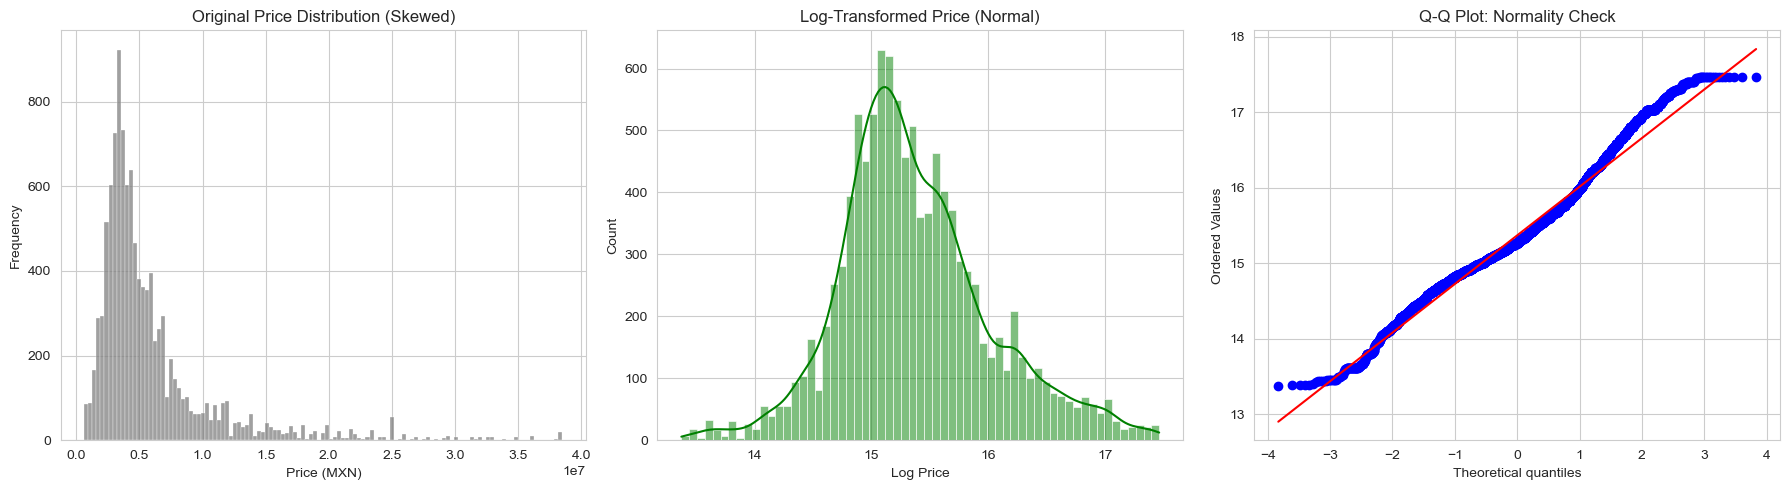

In [9]:
# 3. VISUAL CHECK (Log-Space)

# Vamos a comparar solo el PRECIO para demostrar el impacto de la transformación
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original Price
original_price = np.expm1(df['ln_price'])

sns.histplot(original_price, ax=axes[0], color='gray')
axes[0].set_title('Original Price Distribution (Skewed)')
axes[0].set_xlabel('Price (MXN)')
axes[0].set_ylabel('Frequency')

# Log Price
sns.histplot(df['ln_price'], ax=axes[1], color='green', kde=True)
axes[1].set_title('Log-Transformed Price (Normal)')
axes[1].set_xlabel('Log Price')

# QQ Plot
stats.probplot(df['ln_price'], dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot: Normality Check')

plt.tight_layout()
plt.show()

#### 5.2.2. Group B Analysis: Decay Factors (Distance & Crime)
Variables like "Distance to Park" or "Crime Rate" typically exhibit **Diminishing Marginal Utility** (or Disutility).
* *Example:* The price difference between 0km and 1km is huge; between 20km and 21km is negligible.

**Strategy:**
1.  **Skewness Check:** Identify variables with a long tail (Skew > 1.0).
2.  **Log-Transformation:** Apply `log(x+1)` to linearize these relationships for the regression model.

Analyzing 18 variables for skewness...

Transformed 7 variables (Skew > 1.0).
   - feat_dist_mall: Skew=1.28 -> created 'ln_dist_mall'
   - feat_dist_park: Skew=1.49 -> created 'ln_dist_park'
   - feat_dist_industrial: Skew=1.92 -> created 'ln_dist_industrial'


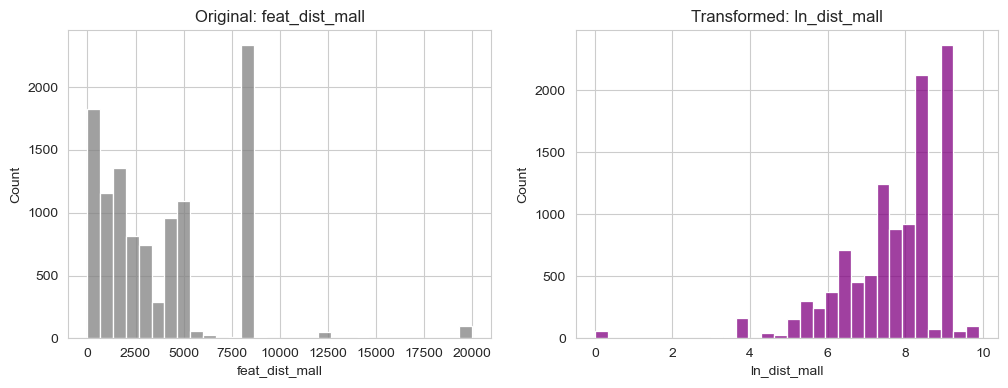

In [10]:
# --- GROUP B: SKEWNESS & LOG TRANSFORMATION ---

skewed_feats = []
print(f"Analyzing {len(group_b_decay)} variables for skewness...")

for col in group_b_decay:
    skew = df[col].skew()

    # Apply Log if Skewness > 1.0 (Right-skewed)
    if skew > 1.0:
        new_col = f"ln_{col.replace('feat_', '')}"
        df[new_col] = np.log1p(df[col])
        skewed_feats.append((col, skew))

print(f"\nTransformed {len(skewed_feats)} variables (Skew > 1.0).")
# Show top 3 examples
for original, val in skewed_feats[:3]:
    print(f"   - {original}: Skew={val:.2f} -> created 'ln_{original.replace('feat_', '')}'")

# Visual Proof (Before vs After)
if skewed_feats:
    example_col = skewed_feats[0][0]
    example_log = f"ln_{example_col.replace('feat_', '')}"

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df[example_col], ax=ax[0], color='gray', bins=30).set_title(f'Original: {example_col}')
    sns.histplot(df[example_log], ax=ax[1], color='purple', bins=30).set_title(f'Transformed: {example_log}')
    plt.show()

Applying a Log transformation is aggressive. While it fixes Right-Skewness (positive skew), it risks **"Overshooting"**: compressing the data so much that it creates a massive Left-Skew (negative skew).

**Verification Criterion:**
We compare the absolute skewness before and after transformation ($|Skew_{new}| < |Skew_{old}|$).
* **Improved:** The distribution is closer to a Normal shape (0 skew).
* **Overshot:** The transformation was too strong, inverting the skew excessively.
    * *Note:* In economic variables (like distance), we often tolerate a slight overshoot if it linearizes the relationship with Price, even if the distribution isn't perfectly normal.

In [14]:
# --- GROUP B: TRANSFORMATION QUALITY CHECK ---

print(f"{'Variable':<30} | {'Orig Skew':<10} | {'Log Skew':<10} | {'Status'}")
print("-" * 75)

# Iterate only through transformed variables
transformed_cols = [c for c in df.columns if c.startswith('ln_') and c not in ['ln_price', 'ln_m2_constructed', 'ln_m2_terrain']]

for log_col in transformed_cols:
    # Reconstruct original column name (remove 'ln_' prefix)
    orig_col = f"feat_{log_col.replace('ln_', '')}"

    if orig_col in df.columns:
        orig_skew = df[orig_col].skew()
        new_skew = df[log_col].skew()

        # Check if absolute skewness was reduced (closer to 0)
        # We use abs() because -1.5 is just as bad as +1.5
        improved = abs(new_skew) < abs(orig_skew)

        status = "Improved" if improved else "Overshot **"

        print(f"{orig_col:<30} | {orig_skew:>9.2f}  | {new_skew:>9.2f}  | {status}")

Variable                       | Orig Skew  | Log Skew   | Status
---------------------------------------------------------------------------
feat_dist_mall                 |      1.28  |     -1.69  | Overshot **
feat_dist_park                 |      1.49  |     -0.47  | Improved
feat_dist_industrial           |      1.92  |     -2.27  | Overshot **
feat_dist_green_area           |      1.39  |     -0.61  | Improved
feat_dist_service              |      1.28  |     -0.49  | Improved
feat_dist_convenience          |      4.39  |     -0.58  | Improved
feat_dist_supermarket          |      1.45  |     -0.36  | Improved


Our initial analysis revealed that the **Log transformation** was too aggressive for certain variables (e.g., `dist_mall`, `dist_industrial`), flipping a moderate positive skew into a strong negative skew ("Overshooting").

**Decision:**
Instead of testing an exhaustive list of functions, we apply a pragmatic **Binary Choice Strategy**:
1.  **Log ($ln(x+1)$):** Best for heavy tails and exponential decay.
2.  **Square Root ($\sqrt{x}$):** A milder transformation, ideal for moderate skewness where Log is too strong.

We will calculate the skewness for both and select the one that brings the distribution closest to zero.

In [15]:
# --- OPTIMIZED GROUP B TRANSFORMATION ---

for col in group_b_decay:
    skew_orig = df[col].skew()

    if skew_orig > 1.0:

        log_val = np.log1p(df[col])
        sqrt_val = np.sqrt(df[col])

        skew_log = log_val.skew()
        skew_sqrt = sqrt_val.skew()

        # Decision Rule: Choose the one closest to 0
        if abs(skew_log) < abs(skew_sqrt):
            # Log wins
            df[f"ln_{col.replace('feat_', '')}"] = log_val
            method = "Log"
            final_skew = skew_log
        else:
            # Sqrt wins (Note: we still prefix 'ln_' or change to 'sqrt_' to keep track)
            df[f"sqrt_{col.replace('feat_', '')}"] = sqrt_val
            method = "Sqrt"
            final_skew = skew_sqrt

        print(f"Variable: {col:<25} | Orig: {skew_orig:.2f} -> New: {final_skew:.2f} ({method})")

Variable: feat_dist_mall            | Orig: 1.28 -> New: 0.22 (Sqrt)
Variable: feat_dist_park            | Orig: 1.49 -> New: -0.47 (Log)
Variable: feat_dist_industrial      | Orig: 1.92 -> New: 0.34 (Sqrt)
Variable: feat_dist_green_area      | Orig: 1.39 -> New: 0.48 (Sqrt)
Variable: feat_dist_service         | Orig: 1.28 -> New: -0.49 (Log)
Variable: feat_dist_convenience     | Orig: 4.39 -> New: -0.58 (Log)
Variable: feat_dist_supermarket     | Orig: 1.45 -> New: -0.36 (Log)


We achieved skewness values between **$\pm 0.6$** for all variables using simple transformations (Log & Sqrt). While algorithms like `PowerTransformer` (Yeo-Johnson) could theoretically push skewness closer to exactly 0, we deliberately stop here for three reasons:

1.  **Explainability:** Log and Sqrt have clear economic interpretations (diminishing marginal utility). Complex fractional powers (e.g., $x^{-0.32}$) are "black boxes" to stakeholders.
2.  **Diminishing Returns:** For a Linear Regression model, the current distribution shapes are sufficient to satisfy linearity assumptions. Further optimization yields negligible predictive gains.
3.  **Robustness:** Simpler transformations are less prone to overfitting and easier to maintain in a production pipeline than data-dependent lambdas.

We consider "Decay Factors" (Group B) to be now statistically healthy and ready for modeling.

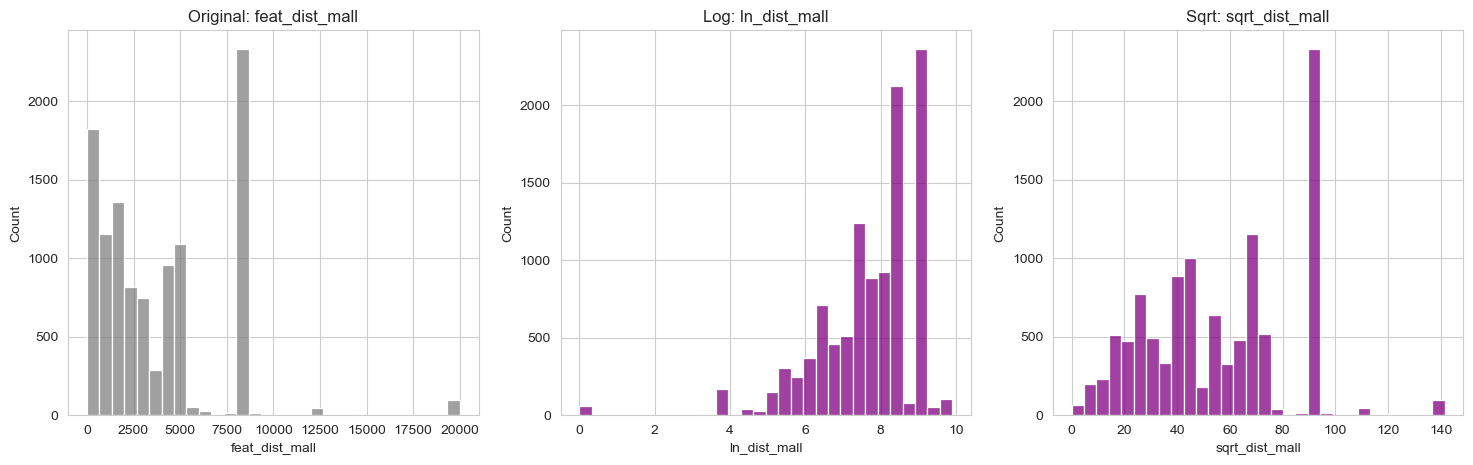

In [20]:
example_col = 'feat_dist_mall'
example_log = f"ln_{example_col.replace('feat_', '')}"
example_sqrt = f"sqrt_{example_col.replace('feat_', '')}"

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df[example_col], ax=ax[0], color='gray', bins=30).set_title(f'Original: {example_col}')
sns.histplot(df[example_log], ax=ax[1], color='purple', bins=30).set_title(f'Log: {example_log}')
sns.histplot(df[example_sqrt], ax=ax[2], color='purple', bins=30).set_title(f'Sqrt: {example_sqrt}')
plt.show()

#### 5.2.3. Group C Analysis: Discrete Counters
These variables (Bedrooms, Bathrooms, Parking) were capped and cleaned in **Stage A**.
Here, we visualize their distribution to confirm they are well-behaved and ready for modeling. No further filtering is required.

--- GROUP C SUMMARY (Post-Stage A Capping) ---
      feat_bedrooms  feat_bathrooms  feat_parking_spots
min           1.000           1.000               0.000
max          10.000          10.000              10.000
mean          3.296           3.020               2.367


C:\Users\a-b-e\AppData\Local\Temp\ipykernel_24184\4210016001.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], ax=axes[i], palette='viridis')
C:\Users\a-b-e\AppData\Local\Temp\ipykernel_24184\4210016001.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], ax=axes[i], palette='viridis')
C:\Users\a-b-e\AppData\Local\Temp\ipykernel_24184\4210016001.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], ax=axes[i], palette='viridis')


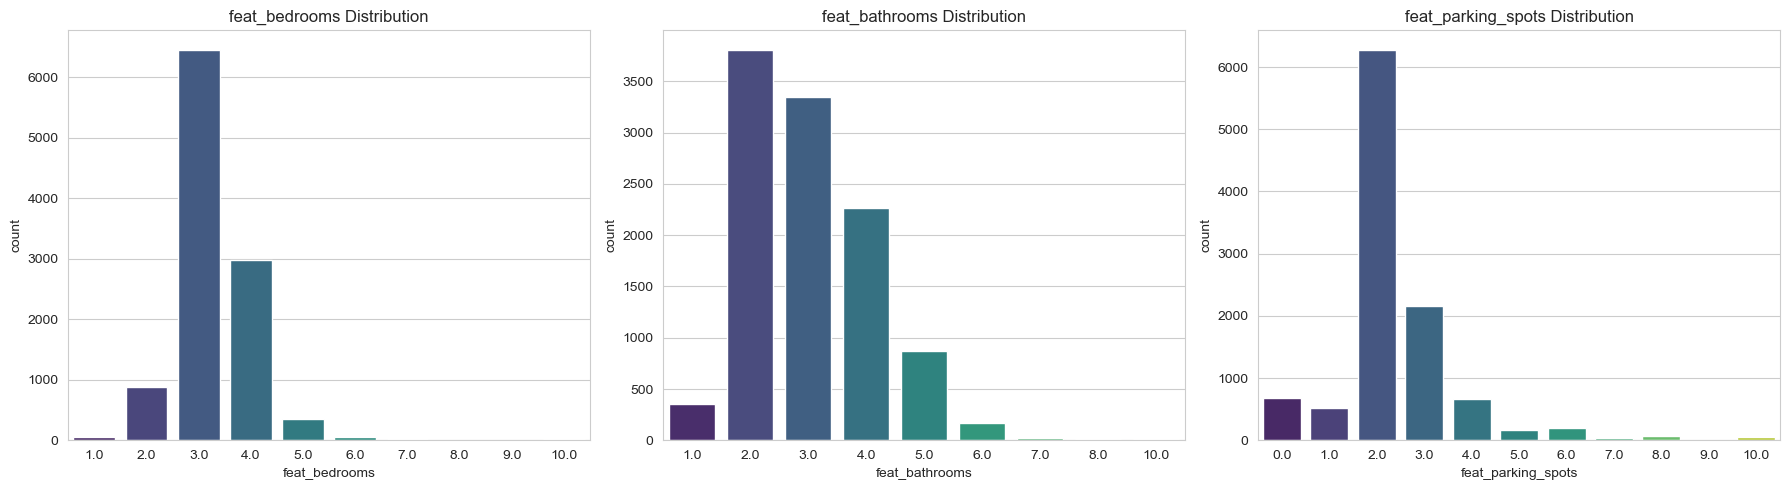

In [8]:
# --- GROUP C: DISTRIBUTION CHECK ---

# No filtering here. Just confirmation.
print(f"--- GROUP C SUMMARY (Post-Stage A Capping) ---")
print(df[group_c_counters].describe().loc[['min', 'max', 'mean']])

# Visual Check using Countplots (better for discrete data than histograms)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot first 3 counters as sanity check
for i, col in enumerate(group_c_counters[:3]):
    if i < 3:
        sns.countplot(x=df[col], ax=axes[i], palette='viridis')
        axes[i].set_title(f'{col} Distribution')

plt.tight_layout()
plt.show()

#### 5.2.4. Group D Analysis: Boolean & Categorical Variance
This group includes binary amenities (Pool, Gym) and the One-Hot Encoded municipalities from Stage A.

**Strategy:**
* **Low Variance Filter:** If a feature is present/absent in more than **99.5%** of the data, it lacks sufficient variance to be predictive and is removed to reduce noise.

In [9]:
# --- GROUP D: LOW VARIANCE FILTER ---

# Threshold: 99.5% constant (e.g., if only 0.5% of houses have a "Tennis Court")
variance_threshold = 0.995
cols_to_drop = []

print(f"Checking {len(group_d_booleans)} boolean variables for low variance...")

for col in group_d_booleans:
    # Calculate frequency of the most common value
    top_freq = df[col].value_counts(normalize=True).iloc[0]

    if top_freq > variance_threshold:
        cols_to_drop.append((col, top_freq))

# Execution
if cols_to_drop:
    print(f"\nDROPPING {len(cols_to_drop)} columns (Constant > {variance_threshold*100}%):")
    for col, freq in cols_to_drop:
        print(f"   - {col}: {freq:.2%} constant")

    # Drop from dataframe
    drop_list = [x[0] for x in cols_to_drop]
    df.drop(columns=drop_list, inplace=True)
else:
    print("\nAll boolean variables have sufficient variance.")

print(f"\n--- FINAL DATASET SHAPE: {df.shape} ---")

Checking 22 boolean variables for low variance...

DROPPING 9 columns (Constant > 99.5%):
   - muni_ARROYO SECO: 99.51% constant
   - muni_CADEREYTA DE MONTES: 99.92% constant
   - muni_COLON: 99.96% constant
   - muni_EZEQUIEL MONTES: 99.89% constant
   - muni_JALPAN DE SERRA: 99.99% constant
   - muni_PEDRO ESCOBEDO: 99.93% constant
   - muni_PENAMILLER: 99.98% constant
   - muni_PINAL DE AMOLES: 100.00% constant
   - muni_TOLIMAN: 99.97% constant

--- FINAL DATASET SHAPE: (10847, 47) ---


## 6. Diagnosing Multicollinearity (The "Bedroom" Issue)

To confirm why the bedroom coefficient is negative, we need to check how strongly the physical variables relate to each other.

**Tools used:**
1.  **Correlation Matrix:** Visual inspection of relationships.
2.  **VIF (Variance Inflation Factor):** A statistical measure quantifying how much the variance of a coefficient is inflated due to multicollinearity.
    * *Rule of Thumb:* VIF > 5 indicates high multicollinearity. VIF > 10 requires immediate action (dropping variables).

In [ ]:
# --- A. Correlation Matrix Heatmap ---
# Calculate correlation matrix
corr_matrix = df[['target_price', 'feat_bedrooms', 'feat_bathrooms',
                  'feat_m2_constructed', 'feat_parking_spots']].corr()

# Plot
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Hide upper triangle

sns.heatmap(corr_matrix,
            mask=mask,
            annot=True,
            fmt=".2f",
            cmap='RdBu_r',
            vmax=1,
            vmin=-1,
            linewidths=.5)

plt.title('Correlation: Physical Features vs Price', fontsize=14)
plt.show()

# --- B. Variance Inflation Factor (VIF) Calculation ---
# Select only numeric features for VIF check (excluding target)
features_for_vif = df[['feat_bedrooms', 'feat_bathrooms',
                       'feat_m2_constructed', 'feat_parking_spots']].dropna()

# Create VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = features_for_vif.columns
vif_data["VIF"] = [variance_inflation_factor(features_for_vif.values, i)
                   for i in range(len(features_for_vif.columns))]

print("\n--- Variance Inflation Factor (VIF) Results ---")
print(vif_data.sort_values(by="VIF", ascending=False))